# Food Vision Project


In this notebook we're going to construct neural network models to perform classification of images into one of the 101 categories as defined in the Food101 dataset.

Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**.

We're going to perform the following with TensorFlow:

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
- Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food

In [1]:
#Check GPU
!nvidia-smi

Sun Dec 15 17:29:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import helper functions file
!wget https://raw.githubusercontent.com/chiragdaryani/food-vision-efficientnet/main/helper_functions.py

--2024-12-15 17:29:56--  https://raw.githubusercontent.com/chiragdaryani/food-vision-efficientnet/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10127 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0.001s  

2024-12-15 17:29:56 (17.6 MB/s) - ‘helper_functions.py’ saved [10127/10127]



In [3]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We're going to see how our model's go with 10% of the training data. This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

## Downloading and preprocessing the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Extract dataset (already preformatted by us)

unzip_data("/content/drive/MyDrive/101_food_classes_10_percent.zip")
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [9]:
# No of images/classes
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/garlic_bread'.
There are 0 directories and 75

In [10]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

#Function to turn our images and labels into a TensorFlow datatype which allows for us to pass it directory to our model.
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


There are 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images).



## Training an EfficientNet Model with transfer learning on 10% of 101 food classes

We're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) with 10% of the training data.  We'll be using:
* A `ModelCheckpoint` callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) `EfficientNetB0` architecture from `tf.keras.applications` as our base model
* A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
* Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

In [12]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [14]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),      # randomly flip images on horizontal edge
  layers.RandomRotation(0.2),           # randomly rotate images by a specific amount
  layers.RandomHeight(0.2),             # randomly adjust the height of an image by a specific amount
  layers.RandomWidth(0.2),              # randomly adjust the width of an image by a specific amount
  layers.RandomZoom(0.2),               # randomly zoom into an image
  # layers.Rescaling(1./255)             # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")


In [15]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) #`include_top=False` so we can add on our own output layers
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Get a summary of our model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

It seems the only trainable parameters are within the `output_layer` which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model (`EfficientNetb0`) frozen whilst allowing the model to tune its outputs to our custom data.


In [17]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 61s 198ms/step - accuracy: 0.1273 - loss: 4.0689 - val_accuracy: 0.3702 - val_loss: 2.8084
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.4034 - loss: 2.6180 - val_accuracy: 0.3896 - val_loss: 2.3600
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.4829 - loss: 2.1885 - val_accuracy: 0.5628 - val_loss: 1.8244
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.5274 - loss: 1.9698 - val_accuracy: 0.5596 - val_loss: 1.7965
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.5688 - loss: 1.8031 - val_accuracy: 0.6107 - val_loss: 1.5658


Our model is getting some impressive results, but note that, during training our model only evaluated on 15% of the test data. Let's see how it did on the whole test dataset.

In [18]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.5011 - loss: 1.9488


[1.820209264755249, 0.5340989828109741]

Well it looks like **we just beat our baseline (the results from the original Food101 paper) with 10% of the data**!

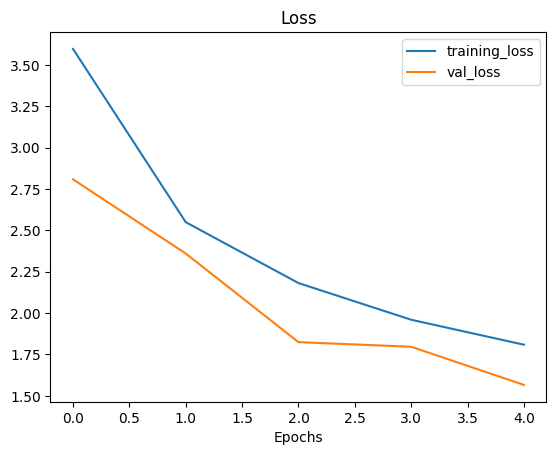

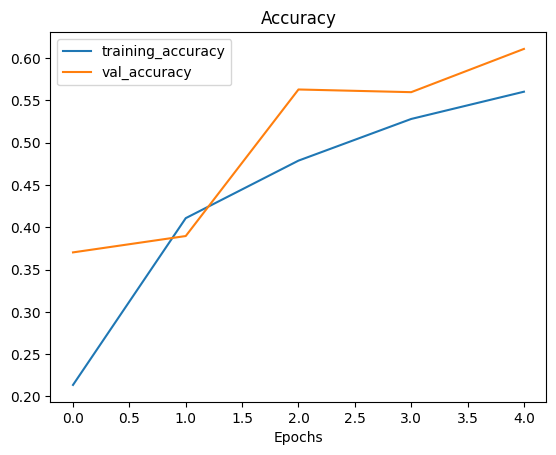

In [19]:
plot_loss_curves(history_all_classes_10_percent)

### Fine-tuning

Our feature extraction transfer learning model is performing well. We now try to fine-tune a few layers in the base model and see if we gain any improvements.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen. We'll refreeze every layer except for the last 5, making them trainable.

In [20]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [21]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [22]:
# Check What layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [23]:
# Check which layers are trainable in the base EfficientNet model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

For fine tuning our model, let's try training for 5 more epochs and see whether we get any benefits

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [24]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 185ms/step - accuracy: 0.5792 - loss: 1.7767 - val_accuracy: 0.4966 - val_loss: 1.9806
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.6065 - loss: 1.5839 - val_accuracy: 0.5281 - val_loss: 1.7978
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.6303 - loss: 1.4901 - val_accuracy: 0.5927 - val_loss: 1.6092
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.6463 - loss: 1.4073 - val_accuracy: 0.5681 - val_loss: 1.6606
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.6619 - loss: 1.3448 - val_accuracy: 0.6261 - val_loss: 1.4417
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.6740 - loss: 1.3127 - val_accuracy: 0.6014 - val_loss: 1.4778


Once again, during training we were only evaluating on a small portion of the test data, let's find out how our model went on all of the test data.

In [25]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5479 - loss: 1.7241


[1.6208841800689697, 0.5732673406600952]

It looks like our model got a slight boost from fine-tuning.
Let's plot the training curves now.

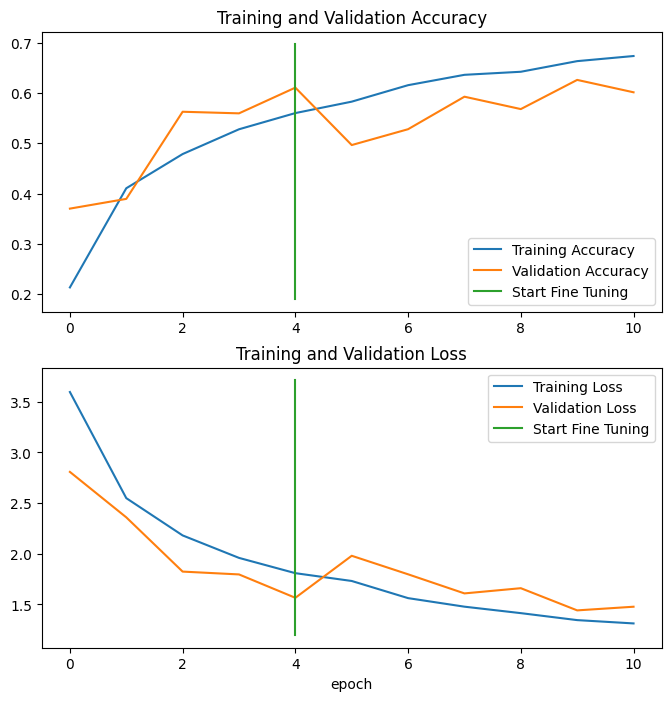

In [26]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit. So let's not train it for more epochs.

### Saving our trained model

To prevent having to retrain our model from scratch, let's save it to file using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

In [28]:
# # Save model to drive so it can be used later
model.save("drive/My Drive/101_food_class_10_percent_saved_model.keras")

In [33]:
# Load back the model
import numpy as np
import tensorflow as tf
import keras
saved_model_path = "drive/My Drive/101_food_class_10_percent_saved_model.keras"
unzip_data(saved_model_path)
model = keras.models.load_model(saved_model_path)

In [34]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 78ms/step - accuracy: 0.5264 - loss: 1.8313


(1.6926350593566895, 0.5572673082351685)

It looks like our loaded model is performing just as well as it was before we saved it. Now let's make some predictions.

## Evaluating the performance of our fine tuned model across all different classes


We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.
Let's dive a little deeper into our model's performance and get some visualizations going to analyze the performance of our model across each of the 101 classes.

### Making predictions with our trained model


To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

Since our data is multi-class, predict() will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [35]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 74ms/step


We just passed all of the test images to our model and asked it to make a prediction on what food it thinks is in each.

In [36]:
# Check how many predictions are there
len(pred_probs)

25250

In [37]:
# Check What's the shape of our predictions
pred_probs.shape

(25250, 101)

This is the **predictions probability tensor** (or array).

Let's see what the first 10 look like.

In [38]:
pred_probs[:10] #prediction probabilities for first 10 images

array([[2.3257217e-01, 2.5536625e-03, 7.8561530e-02, ..., 1.2089326e-04,
        1.2762913e-03, 8.3776219e-03],
       [9.2278290e-01, 5.6386125e-06, 3.1266233e-04, ..., 1.8841124e-03,
        1.1556471e-05, 1.6688313e-05],
       [2.9758435e-01, 1.3338294e-02, 3.7375556e-03, ..., 1.3673685e-03,
        2.8532304e-04, 4.9423091e-03],
       ...,
       [1.4597608e-01, 1.4466881e-05, 4.7812157e-04, ..., 2.0212409e-01,
        4.8663287e-04, 9.0373018e-05],
       [5.6239322e-02, 1.3734364e-03, 8.9595187e-03, ..., 1.7826670e-03,
        2.3682977e-04, 2.8740813e-04],
       [3.1445798e-01, 2.0979962e-05, 9.5383980e-04, ..., 8.7562576e-03,
        2.3864273e-05, 2.1941287e-03]], dtype=float32)

In [39]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0 is {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [2.32572168e-01 2.55366252e-03 7.85615295e-02 1.67790586e-06
 7.07514982e-06 5.99664190e-06 2.69306591e-04 1.01245132e-04
 2.43169814e-02 1.11646776e-03 1.19982087e-05 8.97197242e-05
 1.26224465e-03 7.88996567e-06 6.81139017e-03 2.12177605e-04
 2.85403603e-05 1.18685910e-03 5.09415939e-03 1.08830336e-05
 2.32187891e-03 5.53415484e-05 9.72290654e-05 1.00206491e-03
 1.01612066e-04 2.39864993e-03 3.40217655e-03 2.26370903e-04
 6.15386814e-02 4.26750485e-04 1.19879996e-06 9.28868423e-04
 1.96075358e-04 7.20301832e-05 9.00925719e-04 5.87338436e-05
 1.56336161e-03 5.12549188e-03 1.67569742e-02 3.39385115e-05
 1.44682970e-04 1.42550014e-03 3.96181550e-03 4.88099213e-05
 2.80530483e-04 1.27829817e-05 9.18193080e-04 1.12992617e-04
 1.93534106e-05 4.56136987e-02 1.51958037e-02 3.42394662e-04
 2.69272447e-01 2.64504272e-02 5.13861196e-05 1.47060947e-02
 1.34744812e-02 1.26266899e-03 1.63953623e-

For each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax"`), it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [40]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10] #pred classes for first 10 images

array([52,  0,  0, 42,  8, 78, 29, 98,  9,  0])

We've now got the predicted class index for each of the samples in our test dataset. We'll be able to compare these to the test dataset labels to further evaluate our model.

In [41]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

y_labels[:10] # check what labels for first 10 images look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since `test_data` isn't shuffled, the `y_labels` array comes back in the same order as the `pred_classes` array.

In [42]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

As expected, the number of labels matches the number of images we've got. Now we compare our model's predictions with the ground truth labels.

### Evaluating our models predictions

Let's use `accuracy_score()` function which compares truth labels to predicted labels and returns an accuracy score.

In [43]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5572673267326733

Let's make `make_confusion_matrix`

In [44]:
from helper_functions import make_confusion_matrix

In [45]:
#Reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

Get actual class names using the `class_names` attribute on our `test_data` object.

In [46]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [47]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

The majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visually similar, such as predicting `filet_mignon` for instances of `steak` and `chocolate_cake` for instances of `tiramisu`.


In [48]:
#The `classification_report()` outputs the precision, recall and f1-score's per class.
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.33      0.16      0.22       250
           1       0.34      0.80      0.48       250
           2       0.81      0.33      0.47       250
           3       0.80      0.44      0.57       250
           4       0.45      0.50      0.47       250
           5       0.40      0.32      0.36       250
           6       0.85      0.55      0.67       250
           7       0.72      0.78      0.75       250
           8       0.31      0.36      0.33       250
           9       0.29      0.72      0.41       250
          10       0.44      0.40      0.42       250
          11       0.89      0.34      0.49       250
          12       0.81      0.51      0.62       250
          13       0.38      0.66      0.48       250
          14       0.47      0.57      0.51       250
          15       0.52      0.23      0.32       250
          16       0.74      0.40      0.52       250
          17       0.37    

In [49]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3333333333333333,
  'recall': 0.16,
  'f1-score': 0.21621621621621623,
  'support': 250.0},
 '1': {'precision': 0.3448275862068966,
  'recall': 0.8,
  'f1-score': 0.4819277108433735,
  'support': 250.0},
 '2': {'precision': 0.8118811881188119,
  'recall': 0.328,
  'f1-score': 0.4672364672364672,
  'support': 250.0},
 '3': {'precision': 0.8043478260869565,
  'recall': 0.444,
  'f1-score': 0.5721649484536082,
  'support': 250.0},
 '4': {'precision': 0.4483985765124555,
  'recall': 0.504,
  'f1-score': 0.4745762711864407,
  'support': 250.0},
 '5': {'precision': 0.3951219512195122,
  'recall': 0.324,
  'f1-score': 0.35604395604395606,
  'support': 250.0},
 '6': {'precision': 0.845679012345679,
  'recall': 0.548,
  'f1-score': 0.6650485436893204,
  'support': 250.0},
 '7': {'precision': 0.7211895910780669,
  'recall': 0.776,
  'f1-score': 0.7475915221579962,
  'support': 250.0},
 '8': {'precision': 0.3125,
  'recall': 0.36,
  'f1-score': 0.3345724907063197,
  'support

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called `class_f1_scores` and then loop through each item in `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [50]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.21621621621621623,
 'baby_back_ribs': 0.4819277108433735,
 'baklava': 0.4672364672364672,
 'beef_carpaccio': 0.5721649484536082,
 'beef_tartare': 0.4745762711864407,
 'beet_salad': 0.35604395604395606,
 'beignets': 0.6650485436893204,
 'bibimbap': 0.7475915221579962,
 'bread_pudding': 0.3345724907063197,
 'breakfast_burrito': 0.4133180252583238,
 'bruschetta': 0.42171189979123175,
 'caesar_salad': 0.4913294797687861,
 'cannoli': 0.6240786240786241,
 'caprese_salad': 0.48164464023494863,
 'carrot_cake': 0.5143884892086331,
 'ceviche': 0.31666666666666665,
 'cheese_plate': 0.5219638242894057,
 'cheesecake': 0.41901408450704225,
 'chicken_curry': 0.465324384787472,
 'chicken_quesadilla': 0.6181818181818182,
 'chicken_wings': 0.5538461538461539,
 'chocolate_cake': 0.5203619909502263,
 'chocolate_mousse': 0.23300970873786409,
 'churros': 0.7249466950959488,
 'clam_chowder': 0.7109004739336493,
 'club_sandwich': 0.6403326403326404,
 'crab_cakes': 0.3757115749525617,
 'creme_b

We will now turn our `class_f1_scores` dictionary into a pandas DataFrame and sort it in ascending fashion.

In [51]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33              edamame  0.935849
91  spaghetti_carbonara  0.868313
32            dumplings  0.844262
86              sashimi  0.829787
54    hot_and_sour_soup  0.817006
..                  ...       ...
66               nachos  0.237624
22     chocolate_mousse  0.233010
93                steak  0.230277
0             apple_pie  0.216216
82              ravioli  0.195719

[101 rows x 2 columns]

Let's now make a nice horizontal bar chart.



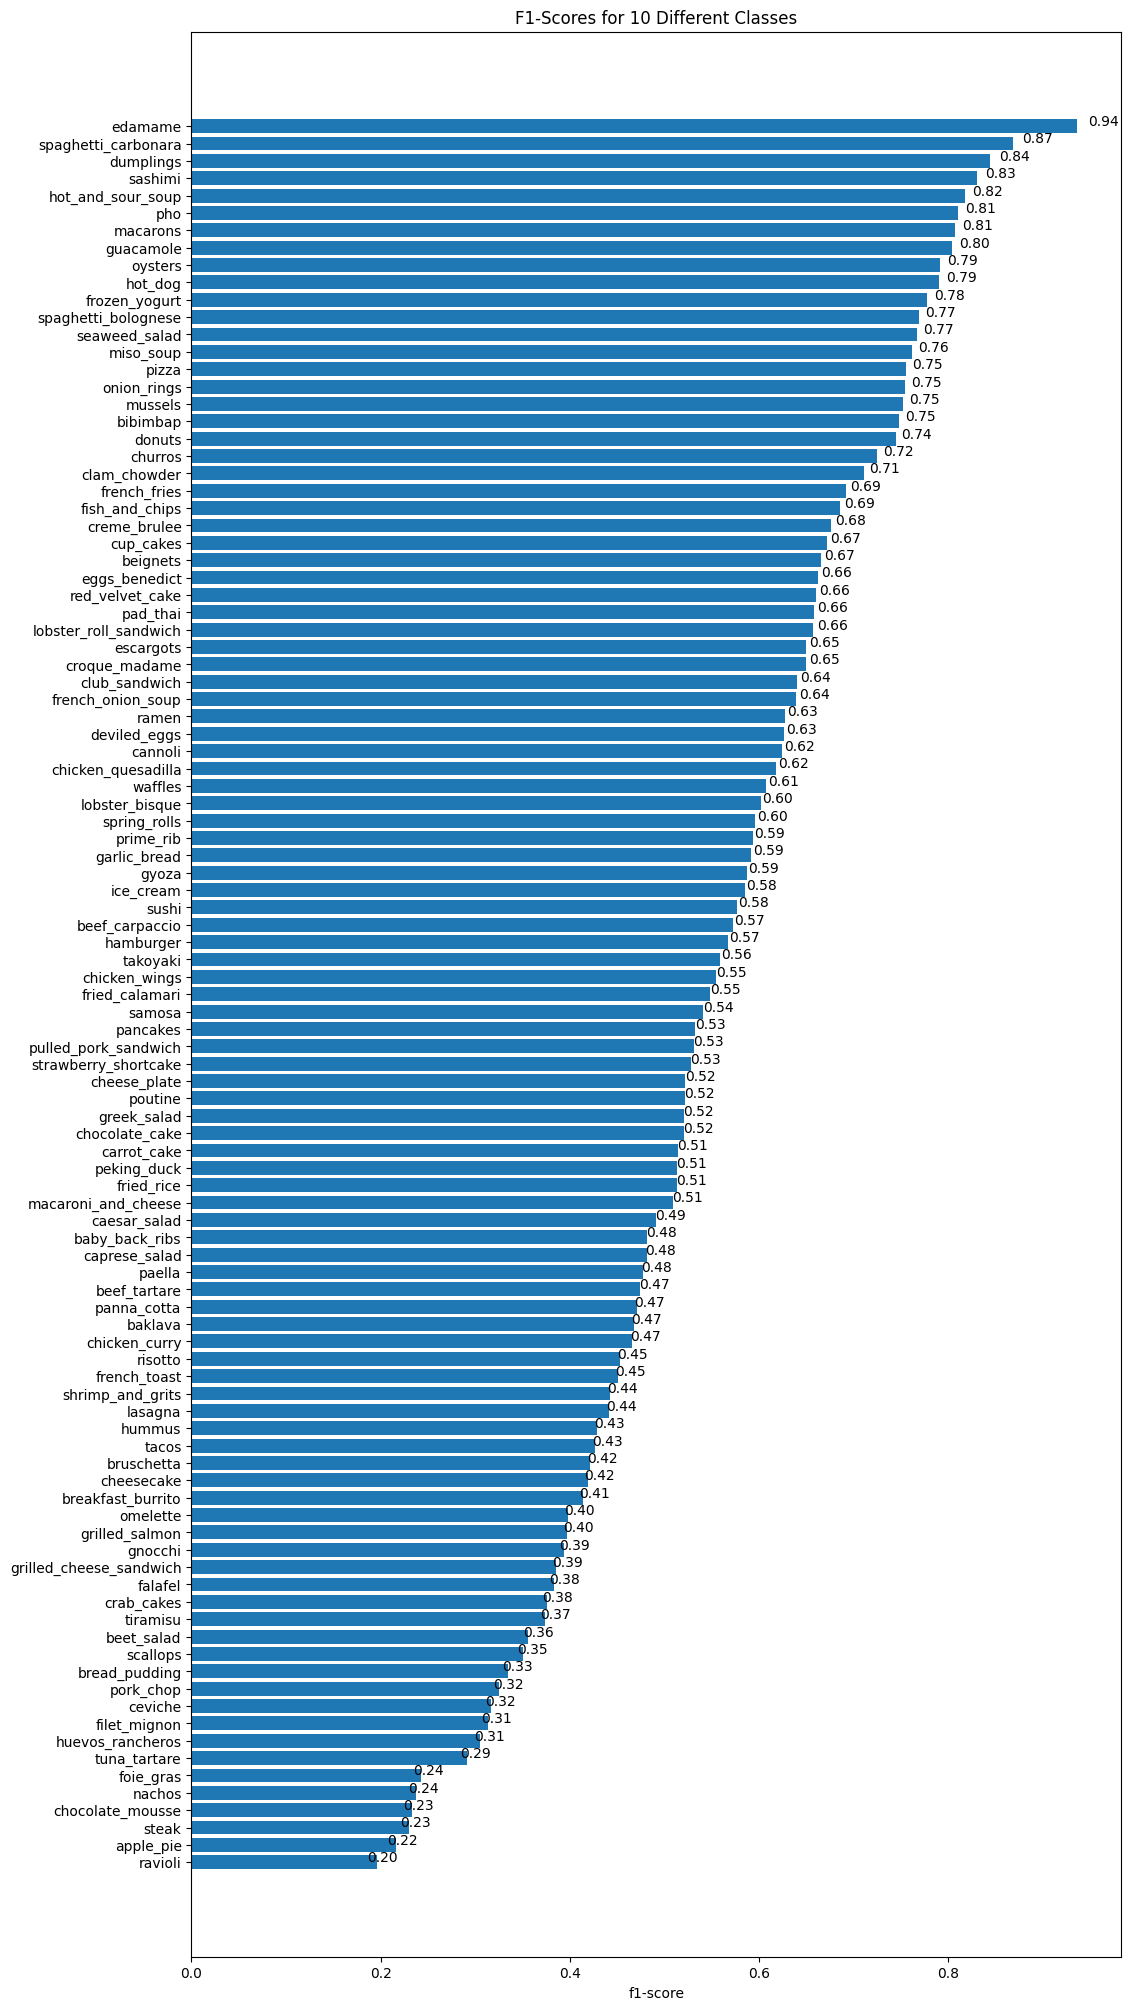

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

Visualizing our model's predictions gives us a completely new insight into its performance rather than just using metrics.

It seems like our model performs fairly poorly on classes like `apple_pie` and `steak` while for classes like `edamame`,`macarons` and `pho` the performance is quite outstanding.

Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

### Visualizing predictions on test images


Now we will perform Visualization of predictions on actual images. Our model can't just predict on any image of our choice. The image first has to be loaded into a tensor. So to begin predicting on any given image, we'll create a function to load an image into a tensor.

In [53]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

We have written functions to perform image loading and preprocessing.

Now let's perform the following:

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


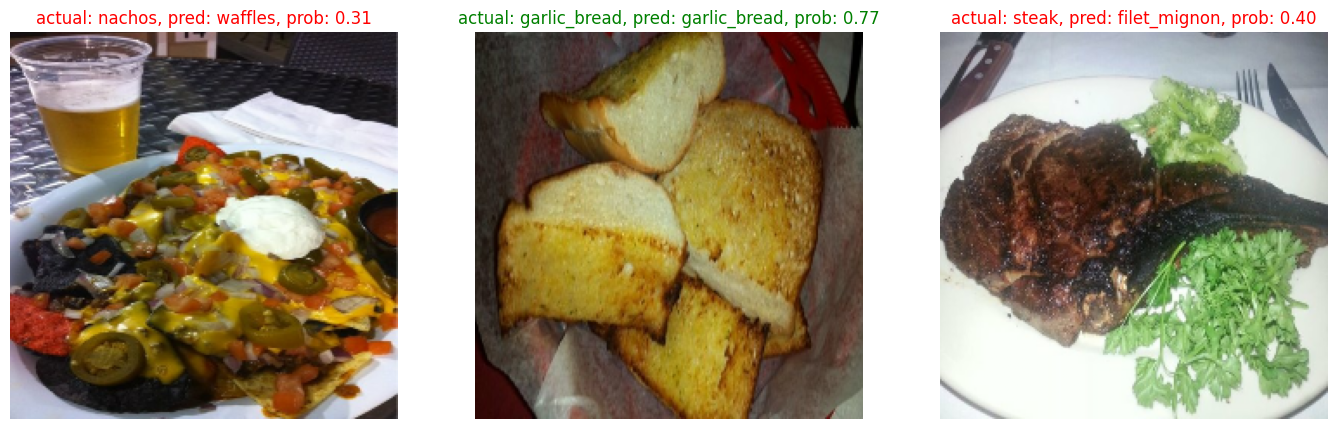

In [54]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3): #3 images will be picked

  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

After going through enough random samples, it starts to become clear that the model tends to make far worse predictions on classes which are visually similar such as `baby_back_ribs` getting mistaken as `steak` and vice versa.

### Finding the most wrong predictions

We'll go through the following steps:
1. Get all of the image file paths in the test dataset using the `list_files()` method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [55]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:
* Their ground truth labels (`y_labels`).
* The class the model predicted (`pred_classes`).
* The maximum prediction probabilitity value (`pred_probs.max(axis=1)`).
* The ground truth class names.
* The predicted class names.

In [56]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      42   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.269272        apple_pie            gyoza  
1   0.922783        apple_pie        apple_pie  
2   0.297584        apple_pie        apple_pie  
3   0.158167        apple_pie     french_toast  
4   0.252276        apple_pie    bread_pudding

In [57]:
# 3. Column for signifying if the prediction is correct
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      42   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.269272        apple_pie            gyoza         False  
1   0.922783        apple_pie        apple_pie          True  
2   0.297584        apple_pie        apple_pie          True  
3   0.158167        apple_pie     french_toast         False  
4   0.252276        apple_pie    bread_pudding         False

We now know which predictions were right or wrong and along with their prediction probabilities. Now we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties.

In [58]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
6108   b'101_food_classes_10_percent/test/clam_chowde...      24      27   
5652   b'101_food_classes_10_percent/test/chocolate_m...      22      98   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
15124  b'101_food_classes_10_percent/test/lobster_bis...      60      27   
9202   b'101_food_classes_10_percent/test/falafel/390...      36      20   
14572  b'101_food_classes_10_percent/test/ice_cream/2...      58      79   
17897  b'101_food_classes_10_percent/test/paella/2986...      71      65   
14482  b'101_food_classes_10_percent/test/hummus/8476...      57      51   
21166  b'101_food_classes_10_percent/test/risotto/313...      84      78   
23300  b'101_food_classes_10_percent/test/steak/17945...      93       1   
19386  b'101_food_classes_10_percent/test/pork_chop/2...      77       1   
10774  b'101_food_classes_10_percent/test/fried_calam...      43      68   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
22606  b'101_food_classes_10_percent/test/spaghetti_b...      90       1   
9440   b'101_food_classes_10_percent/test/filet_migno...      37       1   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
5829   b'101_food_classes_10_percent/test/churros/227...      23      68   
16209  b'101_food_classes_10_percent/test/miso_soup/5...      64      81   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   

       pred_conf       y_true_classname y_pred_classname  pred_correct  
23797   0.995930                  sushi          sashimi         False  
6108    0.993815           clam_chowder     creme_brulee         False  
5652    0.992825       chocolate_mousse         tiramisu         False  
23631   0.991661   strawberry_shortcake  red_velvet_cake         False  
15124   0.991182         lobster_bisque     creme_brulee         False  
9202    0.991081                falafel    chicken_wings         False  
14572   0.991044              ice_cream        prime_rib         False  
17897   0.990918                 paella          mussels         False  
14482   0.989051                 hummus        guacamole         False  
21166   0.989037                risotto          poutine         False  
23300   0.989009                  steak   baby_back_ribs         False  
19386   0.987428              pork_chop   baby_back_ribs         False  
10774   0.987307         fried_calamari      onion_rings         False  
10847   0.986631         fried_calamari      onion_rings         False  
22606   0.985975    spaghetti_bolognese   baby_back_ribs         False  
9440    0.985409           filet_mignon   baby_back_ribs         False  
5114    0.985079          chicken_wings   fish_and_chips         False  
5829    0.984100                churros      onion_rings         False  
16209   0.982913              miso_soup            ramen         False  
15359   0.982820  lobster_roll_sandwich        hamburger         False

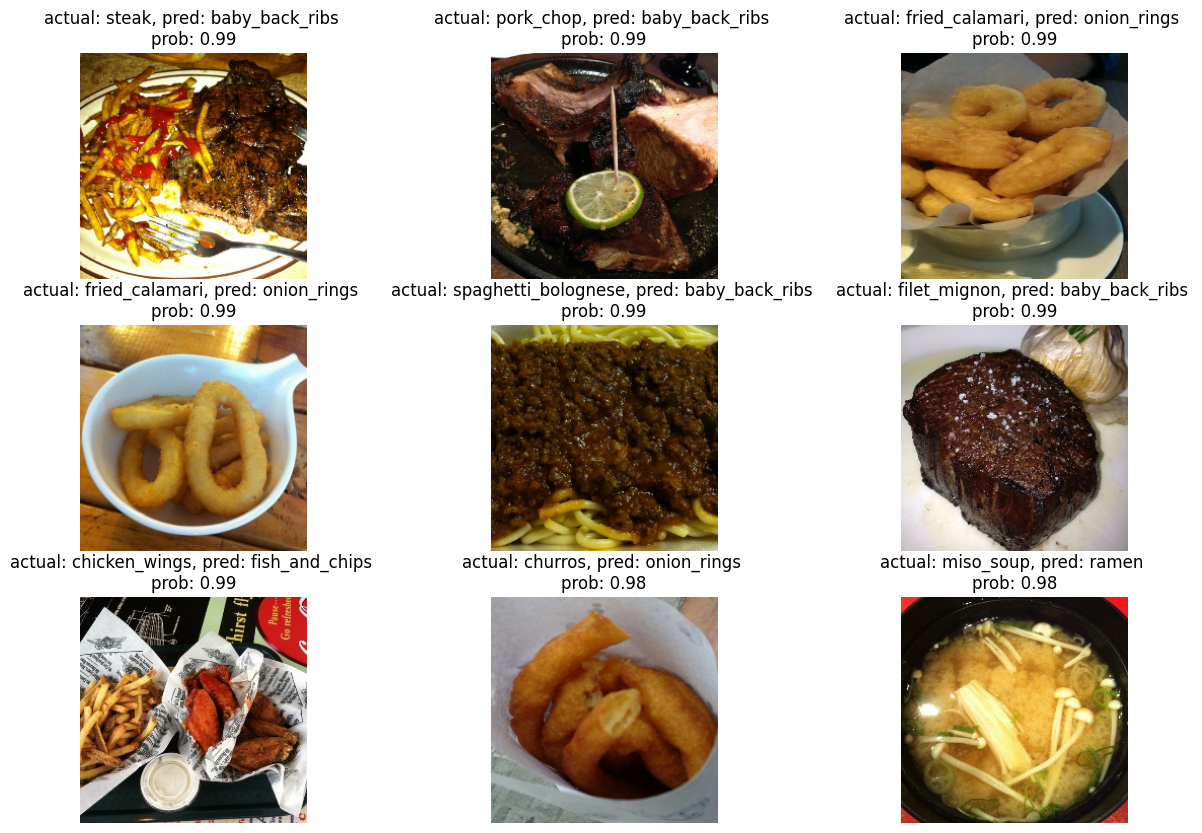

In [59]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  #print(row)
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row. Skip the first 4 parameters, last parameter in tuple
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

By going through the model's most wrong predictions, we could figure out a couple of things:
* **Some of the labels might be wrong** - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This is called "Active Learning"

* **We could collect more samples for some of the classes** - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

## Test out our model on test images as well as custom images of food


In [ ]:
# Download some custom images

unzip_data("custom_food_images.zip")

In [ ]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images[:-1]

Now we can use similar code to what we used previously to load in our images, make a prediction on each using our trained model and then plot the image along with the predicted class.

In [ ]:
# Make predictions on custom food images
for img in custom_food_images[:-1]:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Our model got these incredible results (10%+ better than the baseline) with only 10% of the training images.

If we trained a model with all of the data (100% of the training data from Food101 instead of 10%), we can increase our results even further.